## Домашнее задание №9
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("{} device is available".format(device))
# __________end of block__________

cpu device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-06-02 14:12:57--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.09s   

2024-06-02 14:12:58 (2.71 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [4]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ["<sos>"]
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [5]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx["<sos>"]


def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size * seq_length - 1)
    data = np.array(
        text_encoded[start_index : start_index + batch_size * seq_length]
    ).reshape((batch_size, -1))
    yield np.hstack((start_column, data))


# __________end of block__________

In [7]:
print(type(start_column))

<class 'numpy.ndarray'>


Пример батча:

In [24]:
next(generate_chunk())

array([[83, 45, 55, ..., 47, 53, 54],
       [83,  1, 62, ..., 68, 50, 61],
       [83, 63, 72, ..., 59, 46, 56],
       ...,
       [83,  5,  0, ..., 57, 59, 54],
       [83,  1, 52, ..., 59, 48, 59],
       [83,  1, 62, ..., 73,  1, 49]])

In [25]:
next(generate_chunk()).shape

(256, 101)

Далее вам предстоит написать код для обучения модели и генерации текста.

In [ ]:
# your beautiful experiments here

In [26]:
import torch
from torch.nn import RNN

In [34]:
class RNNCell(nn.Module):
    def __init__(self, num_tokens=84, embedding_size=18, hidden_size=64):
        super(self.__class__, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn = RNN(embedding_size, self.hidden_size, batch_first=True)
        self.rnn_to_logits = nn.Linear(self.hidden_size, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        output, hn = self.rnn(x_emb, h_prev)
        logits = self.rnn_to_logits(output)
        return logits, hn
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, 
                           requires_grad=True).unsqueeze(0)

In [35]:
def rnn_loop(rnn_cell, batch_ix):
    batch_size, max_length = batch_ix.size()
    hn = rnn_cell.initial_state(batch_size)    

    logits, hn = rnn_cell(batch_ix, hn)

        
    return logits

In [36]:
rnn_cell = RNNCell()
history = []
opt = torch.optim.Adam(rnn_cell.parameters())

In [37]:
loss_func = torch.nn.CrossEntropyLoss()

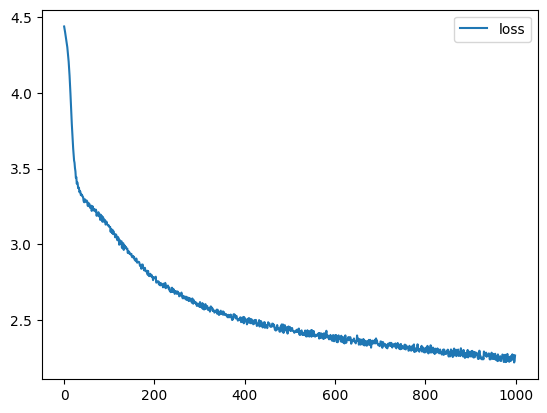

In [38]:
for i in range(1000):
    batch = torch.tensor(next(generate_chunk()))
    
    logits_seq = rnn_loop(rnn_cell, batch)
    
    predictions_logits = logits_seq[:, :-1]
    actual_next_tokens = batch[:, 1:]
    
    loss = loss_func(
        predictions_logits.reshape((-1, num_tokens)), 
        actual_next_tokens.reshape(-1)
    )
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

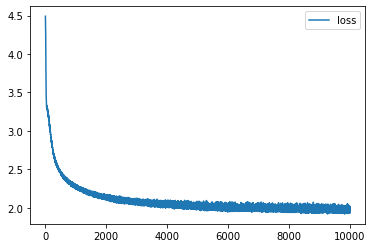

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [ ]:
def generate_sample(
    char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device
):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """

    if seed_phrase is not None:
        x_sequence = [token_to_idx["<sos>"]] + [
            token_to_idx[token] for token in seed_phrase
        ]
    else:
        x_sequence = [token_to_idx["<sos>"]]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    # feed the seed phrase, if any

    # your code here

    return "".join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(
    generate_sample(
        model, " мой дядя самых честных правил", max_length=500, temperature=0.8
    )
)

<sos> мой дядя самых честных правилас;



xiv

но как потокой.



xii

«я свобред не словавран в скорей,
для с посвялесь мне моловой,
те ты,
перегиной в тям праздной
и привезут перваю вся вновся сквозь ти стала сблился,
и старый свимарной таня обратель любова не когда и нет волностье нежной
тишен,
перестоком.
«поже постаничив очествы
в и старько забаньем и заковенью,
ее своя моднать наводушта;
какой нет поли своем горозный и быле и, законно он ходушних недважный плая
с за стра.



xvii




xxvi

все 


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = " мой дядя самых честных правил"

In [ ]:
generated_phrases = # your code here

# For example:

# generated_phrases = [
#     generate_sample(
#         model,
#         ' мой дядя самых честных правил',
#         max_length=500,
#         temperature=1.
#     ).replace('<sos>', '')
#     for _ in range(10)
# ]

In [ ]:
output = {key: ','.join([str(x) for x in list(data.item()[key])]) for key in 'train', 'test'}

In [ ]:
# do not change the code in the block below
# __________start of block__________

if "generated_phrases" not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all(
        [x in set(tokens) for x in set(list(phrase))]
    ), "Unknown tokens detected, check your submission!"


submission_dict = {"token_to_idx": token_to_idx, "generated_phrases": generated_phrases}

np.save("submission_dict_hw09.npy", submission_dict, allow_pickle=True)
print("File saved to `submission_dict_hw09.npy`")
# __________end of block__________

На этом задание завершено. Поздравляем!